In [1]:
import torch
import gpytorch as gp
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(1)
np.random.seed(1)

In [2]:
df = pd.read_csv('C:/Users/tln229/Downloads/Python/Building/data/HVAC_B90_102_exp_10m_20210424.csv')

n_train = 64

# TRAIN SET
Tz_k   = np.array(df['room_temp']).reshape(-1,1)[0: n_train]
Tz_k1  = np.array(df['room_temp'])[1: n_train+1]
Tsa_k1 = np.array(df['supply_discharge_temp']).reshape(-1,1)[1: n_train+1]
msa_k1 = np.array(df['airflow_current']).reshape(-1,1)[1: n_train+1]

train_x = np.concatenate((Tz_k, Tsa_k1, msa_k1), axis=1)
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(Tz_k1, dtype=torch.float32)

# TEST SET
Tz_k   = np.array(df['room_temp']).reshape(-1,1)[n_train:1600]
Tz_k1  = np.array(df['room_temp'])[n_train+1:1600+1]
Tsa_k1 = np.array(df['supply_discharge_temp']).reshape(-1,1)[n_train+1: 1600+1]
msa_k1 = np.array(df['airflow_current']).reshape(-1,1)[n_train+1:1600+1]

test_x = np.concatenate((Tz_k, Tsa_k1, msa_k1), axis=1)
test_x = torch.tensor(test_x, dtype=torch.float32)
test_y = torch.tensor(Tz_k1, dtype=torch.float32)

In [3]:
class MyGPModel(gp.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MyGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module  = gp.means.ZeroMean()                                 # Means
        self.covar_module = gp.kernels.ScaleKernel(gp.kernels.RBFKernel())      # Covariance

    def forward(self, x):
        mean_x  = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gp.likelihoods.GaussianLikelihood()
model      = MyGPModel(train_x, train_y, likelihood)

In [4]:
# Training
training_iter = 150000    # number of training iteration

optimizer = torch.optim.Adam(model.parameters(), lr=0.02)    # optimizer
mll = gp.mlls.ExactMarginalLogLikelihood(likelihood, model)   # marginal likelihood

R2_test = np.array([], dtype=np.float32)
for i in range(training_iter+1):
    # TRAIN
    model.train()                   # find the hyperparameters
    likelihood.train()

    optimizer.zero_grad()           # Zero gradients from previous iteration
    output = model(train_x)         # Output from model
    loss   = -mll(output, train_y)  # Calc loss and backprop gradients

    loss.backward()
    optimizer.step()
    

    # EVAL
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gp.settings.fast_pred_var():
        pred_y = likelihood(model(test_x))

    r2 = r2_score(test_y.numpy(), pred_y.mean.numpy())
    R2_test = np.append(R2_test, r2)
    if (i%1000==0):
        print('Iter %6d/%d - Loss: %10.5f   lengthscale: %7.3f   noise: %6.3f   r2_test: %10.4f' % 
            (i,
            training_iter, 
            loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item(),
            r2
            ),
            )

Iter      0/150000 - Loss: 1552.577   lengthscale:   0.703   noise:  0.703   r2_test: -1395.9588
Iter   1000/150000 - Loss:  107.970   lengthscale:   9.816   noise:  4.327   r2_test:  -406.8424
Iter   2000/150000 - Loss:   62.601   lengthscale:  14.624   noise:  5.662   r2_test:  -233.3328
Iter   3000/150000 - Loss:   43.272   lengthscale:  19.060   noise:  6.656   r2_test:  -141.1359
Iter   4000/150000 - Loss:   32.022   lengthscale:  23.566   noise:  7.493   r2_test:   -85.8521
Iter   5000/150000 - Loss:   24.576   lengthscale:  28.333   noise:  8.232   r2_test:   -52.5057
Iter   6000/150000 - Loss:   19.356   lengthscale:  33.422   noise:  8.890   r2_test:   -31.9304
Iter   7000/150000 - Loss:   15.544   lengthscale:  38.925   noise:  9.463   r2_test:   -19.1597
Iter   8000/150000 - Loss:   12.676   lengthscale:  44.943   noise:  9.920   r2_test:   -11.3627
Iter   9000/150000 - Loss:   10.482   lengthscale:  51.542   noise: 10.191   r2_test:    -6.6419
Iter  10000/150000 - Loss:    

In [5]:
def plot(x, y):
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gp.settings.fast_pred_var():
        observed_pred = likelihood(model(x))

    plt.figure(figsize=(10, 3))
    plt.plot(observed_pred.mean.numpy(), 'r-', label='predict')
    plt.plot(y.numpy(), 'b', label='real')
    plt.legend()
    plt.show()

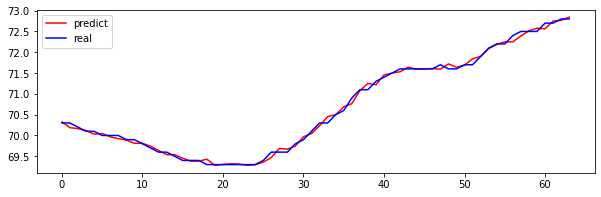

In [6]:
plot(train_x, train_y)

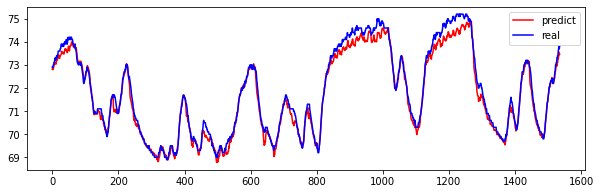

In [7]:
plot(test_x, test_y)

In [8]:
print(np.argmax(R2_test))
print(np.max(R2_test))

148578
0.9821469163575411
